In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import os
import cv2
import numpy as np
from time import time

%matplotlib inline

In [14]:
def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def readimage():
    folder = 'image-cancer/'
    list_images = os.listdir(folder)
    list_img = []
    for i in list_images:
        path = folder+i
        print(path)
        img = cv2.imread(path)
        rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
        list_img.append(rgb_img)
        
    return list_img


In [15]:
list_img = readimage()

n_data = len(list_img)

image-cancer/2.png
image-cancer/braintumor.png
image-cancer/1.png


Image 1
Fuzzy time for cluster 4
1.3923192024230957 seconds
Fuzzy time for cluster 5
2.1046717166900635 seconds
Fuzzy time for cluster 6
2.827436685562134 seconds

Image 2
Fuzzy time for cluster 4
0.9741246700286865 seconds
Fuzzy time for cluster 5
1.5362603664398193 seconds
Fuzzy time for cluster 6
4.750378608703613 seconds

Image 3
Fuzzy time for cluster 4
2.2405896186828613 seconds
Fuzzy time for cluster 5
2.407200813293457 seconds
Fuzzy time for cluster 6
3.4894661903381348 seconds



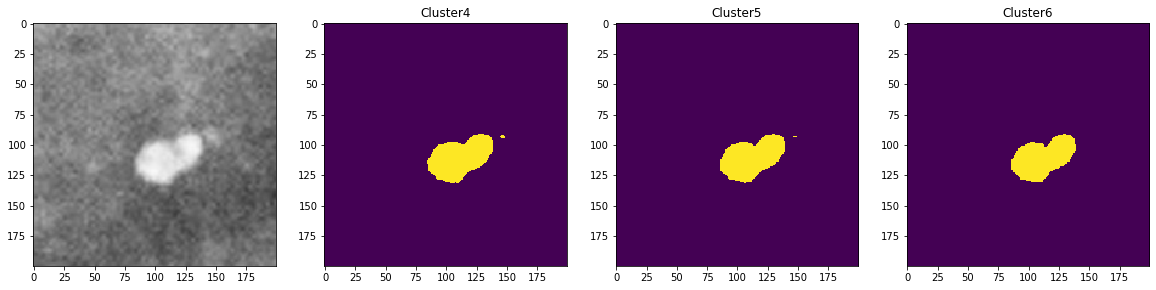

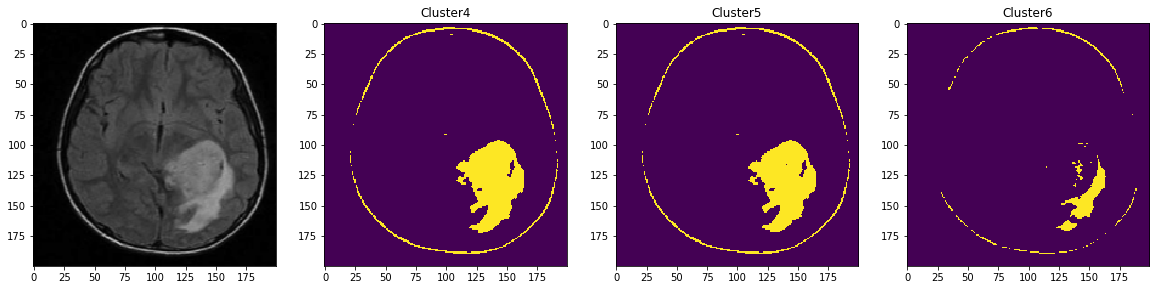

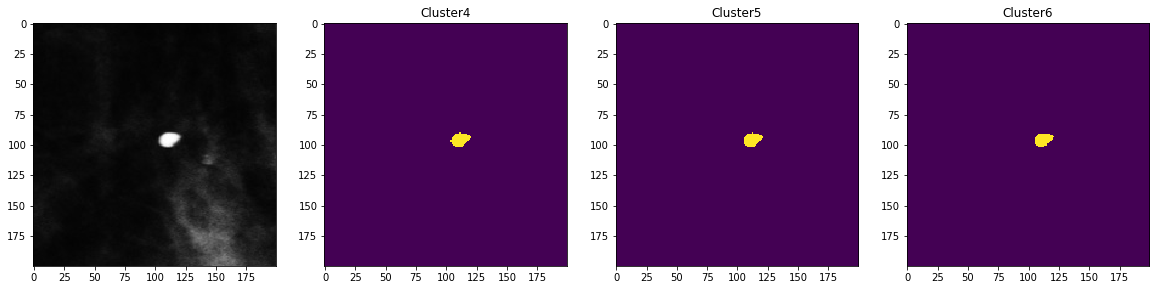

In [16]:
clusters = [4,5,6]

# looping every images
for index,rgb_img in enumerate(list_img):
    img = np.reshape(rgb_img, (200,200,3)).astype(np.uint8)
    shape = np.shape(img)
    
    
    # initialize graph
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    # looping every cluster     
    print('Image '+str(index+1))
    for i,cluster in enumerate(clusters):
            
        # Fuzzy C Means
        new_time = time()
        
        # error = 0.005
        # maximum iteration = 1000
        # cluster = 2,3,6,8
        
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        rgb_img.T, cluster, 2, error=0.005, maxiter=1000, init=None,seed=42)

        new_img = change_color_fuzzycmeans(u,cntr)
        
        fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
        
        ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
        
        print('Fuzzy time for cluster',cluster)
        print(time() - new_time,'seconds')
        seg_img_1d = seg_img[:,:,1]

        plt.subplot(1,4,i+2)
        plt.imshow(seg_img_1d)
        name = 'Cluster'+str(cluster)
        plt.title(name)

    name = 'segmented'+str(index)+'.png'
    plt.savefig(name)
    print()